Imports aus der Vorlesung genommen (nicht sicher ob wir alles brauchen)

In [3659]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, find_peaks, peak_widths, peak_prominences
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Daten laden

In [3660]:
# Laden aller Daten aus dem Ordner: 'csv_data'
def load_csv_data(folder_name):
    data = {}
    csv_folder = os.path.join(os.getcwd(), folder_name)

    if not os.path.exists(csv_folder):
        print(f"Error: The folder '{csv_folder}' was not found.")
        return data
    
    for file in os.listdir(csv_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_folder, file)
            try:
                filename = file.replace('.csv', '')
                data[filename] = pd.read_csv(file_path, delimiter=',')
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return data


In [3661]:
data = load_csv_data('csv_data')
print(data.keys())

try:
    jump_acc = data['Linear_Acceleration_Jump']
    jump_gyr = data['Gyroscope_Jump']
    squat_acc = data['Linear_Acceleration_Squat']
    squat_gyr = data['Gyroscope_Squat']
except KeyError as e:
    print(f"Key not found: {e}")


dict_keys(['Gyroscope_Jump', 'Gyroscope_Squat', 'Linear_Acceleration_Jump', 'Linear_Acceleration_Squat'])


In [3662]:
print("Jump Accelerometer Data:")
print(jump_acc.describe())


Jump Accelerometer Data:
          Time (s)  Linear Acceleration x (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.022010                       0.704642   
std       2.889770                       0.986032   
min       0.024174                      -3.810173   
25%       2.522923                       0.174252   
50%       5.022130                       0.753718   
75%       7.520972                       1.301103   
max      10.019233                       3.623628   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                    1001.000000                    1001.000000  
mean                        0.177169                       0.349645  
std                        12.297720                       2.986639  
min                       -15.460706                      -7.029371  
25%                        -9.752974                      -1.630308  
50%                        -4.991462                       0.126350  
75%    

In [3663]:
print("Jump Gyroscope Data:")
print(jump_gyr.describe())


Jump Gyroscope Data:
          Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  1001.000000          1001.000000          1001.000000   
mean      5.012072            -0.005314             0.001743   
std       2.889771             0.458255             0.218534   
min       0.014226            -1.205879            -0.704140   
25%       2.512944            -0.306264            -0.132625   
50%       5.012181            -0.035154             0.003196   
75%       7.511023             0.249805             0.128897   
max      10.009284             1.778992             0.759001   

       Gyroscope z (rad/s)  
count          1001.000000  
mean              0.009130  
std               0.251720  
min              -0.725978  
25%              -0.159790  
50%              -0.007457  
75%               0.160322  
max               0.805873  


In [3664]:
print("Squat Accelerometer Data:")
print(squat_acc.describe())

Squat Accelerometer Data:
          Time (s)  Linear Acceleration x (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.021009                      -0.052273   
std       2.888940                       0.419312   
min       0.024449                      -1.476752   
25%       2.522863                      -0.351800   
50%       5.020909                      -0.016270   
75%       7.519170                       0.274177   
max      10.017594                       1.061080   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                    1001.000000                    1001.000000  
mean                       -0.145584                       0.492045  
std                         2.907487                       1.188965  
min                        -5.593678                      -2.324644  
25%                        -2.631484                      -0.373079  
50%                        -0.219042                       0.194327  
75%   

In [3665]:
print("Squat Gyroscope Data:")
print(squat_gyr.describe())

Squat Gyroscope Data:
          Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  1001.000000          1001.000000          1001.000000   
mean      5.011073            -0.051974             0.018884   
std       2.888941             0.559377             0.105692   
min       0.014470            -1.126517            -0.259925   
25%       2.512914            -0.499609            -0.052731   
50%       5.010961            -0.075634             0.021838   
75%       7.509221             0.483097             0.084156   
max      10.007646             0.978978             0.308927   

       Gyroscope z (rad/s)  
count          1001.000000  
mean             -0.002028  
std               0.141957  
min              -0.561394  
25%              -0.095874  
50%               0.004261  
75%               0.090015  
max               0.399474  


In [3666]:
def trim_dataframes_to_shortest(df_list):
    # Bestimmen der minimalen Länge aller DataFrames in der Liste
    min_length = min(df.shape[0] for df in df_list)

    # Kürzen aller DataFrames auf die minimale Länge
    trimmed_dfs = [df.iloc[:min_length] for df in df_list]

    return trimmed_dfs

In [3667]:
jump_acc, jump_gyr, squat_acc, squat_gyr = trim_dataframes_to_shortest([jump_acc, jump_gyr, squat_acc, squat_gyr])

In [3668]:
jump_acc.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.022010,0.704642,0.177169,0.349645
std,2.889770,0.986032,12.297720,2.986639
min,0.024174,-3.810173,-15.460706,-7.029371
25%,2.522923,0.174252,-9.752974,-1.630308
50%,5.022130,0.753718,-4.991462,0.126350
75%,7.520972,1.301103,10.097296,1.730946
max,10.019233,3.623628,31.554523,10.272612


In [3669]:
jump_gyr.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.012072,-0.005314,0.001743,0.009130
std,2.889771,0.458255,0.218534,0.251720
min,0.014226,-1.205879,-0.704140,-0.725978
25%,2.512944,-0.306264,-0.132625,-0.159790
50%,5.012181,-0.035154,0.003196,-0.007457
75%,7.511023,0.249805,0.128897,0.160322
max,10.009284,1.778992,0.759001,0.805873


Funktion zum Plotten

In [3670]:
def compare_acc_gyr(acc_df,gyr_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration x (m/s^2)'], name='Accel X'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope y (rad/s)'], marker=dict(size=4), name='Gyr Y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope z (rad/s)'], marker=dict(size=4), name='Gyr Z'), row=2, col=1)

    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [3671]:
compare_acc_gyr(jump_acc,jump_gyr)

In [3672]:
compare_acc_gyr(squat_acc,squat_gyr)

### Relevante Spalten extrahieren

In [3673]:
print(jump_acc.describe())

          Time (s)  Linear Acceleration x (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.022010                       0.704642   
std       2.889770                       0.986032   
min       0.024174                      -3.810173   
25%       2.522923                       0.174252   
50%       5.022130                       0.753718   
75%       7.520972                       1.301103   
max      10.019233                       3.623628   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                    1001.000000                    1001.000000  
mean                        0.177169                       0.349645  
std                        12.297720                       2.986639  
min                       -15.460706                      -7.029371  
25%                        -9.752974                      -1.630308  
50%                        -4.991462                       0.126350  
75%                        10.09

In [3674]:
print(jump_gyr.describe())

          Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  1001.000000          1001.000000          1001.000000   
mean      5.012072            -0.005314             0.001743   
std       2.889771             0.458255             0.218534   
min       0.014226            -1.205879            -0.704140   
25%       2.512944            -0.306264            -0.132625   
50%       5.012181            -0.035154             0.003196   
75%       7.511023             0.249805             0.128897   
max      10.009284             1.778992             0.759001   

       Gyroscope z (rad/s)  
count          1001.000000  
mean              0.009130  
std               0.251720  
min              -0.725978  
25%              -0.159790  
50%              -0.007457  
75%               0.160322  
max               0.805873  


In [3675]:
def combine_relevant_columns(acc_df, gyr_df):
    linear_acc_z = acc_df['Linear Acceleration z (m/s^2)']
    linear_acc_y = acc_df['Linear Acceleration y (m/s^2)']

    gyroskop_x = gyr_df['Gyroscope x (rad/s)']

    time = gyr_df['Time (s)']

    return pd.DataFrame({
        'Time (s)': time,
        'Linear Acceleration z (m/s^2)': linear_acc_z,
        'Linear Acceleration y (m/s^2)': linear_acc_y,
        'Gyroscope x (rad/s)': gyroskop_x
    })

In [3676]:
combined_df = combine_relevant_columns(jump_acc, jump_gyr)
print(combined_df.describe())

          Time (s)  Linear Acceleration z (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.012072                       0.349645   
std       2.889771                       2.986639   
min       0.014226                      -7.029371   
25%       2.512944                      -1.630308   
50%       5.012181                       0.126350   
75%       7.511023                       1.730946   
max      10.009284                      10.272612   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                    1001.000000          1001.000000  
mean                        0.177169            -0.005314  
std                        12.297720             0.458255  
min                       -15.460706            -1.205879  
25%                        -9.752974            -0.306264  
50%                        -4.991462            -0.035154  
75%                        10.097296             0.249805  
max                        31.554523      

In [3677]:
print(combined_df.describe())


          Time (s)  Linear Acceleration z (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.012072                       0.349645   
std       2.889771                       2.986639   
min       0.014226                      -7.029371   
25%       2.512944                      -1.630308   
50%       5.012181                       0.126350   
75%       7.511023                       1.730946   
max      10.009284                      10.272612   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                    1001.000000          1001.000000  
mean                        0.177169            -0.005314  
std                        12.297720             0.458255  
min                       -15.460706            -1.205879  
25%                        -9.752974            -0.306264  
50%                        -4.991462            -0.035154  
75%                        10.097296             0.249805  
max                        31.554523      

In [3678]:
jump_df = combine_relevant_columns(jump_acc, jump_gyr)

In [3679]:
squat_df = combine_relevant_columns(squat_acc, squat_gyr)

In [3680]:
def plot_frequencies(dataframe):
    plt.figure(figsize=(15, 5))

    filtered_df = dataframe.drop(columns=['Time (s)'])
    num_columns = len(filtered_df.columns)

    for i, column in enumerate(filtered_df.columns, 1):
        dataframe_col = filtered_df[column]
        dft = np.fft.fft(dataframe_col)
        frequencies = np.fft.fftfreq(len(dataframe_col))
        amplitudes = np.abs(dft)

        # Normalisierung der Amplituden
        max_amplitude = np.max(amplitudes)
        normalized_amplitudes = amplitudes / max_amplitude

        # Filtern für positive Frequenzen
        positive_indices = np.where(frequencies > 0)
        positive_frequencies = frequencies[positive_indices]
        positive_normalized_amplitudes = normalized_amplitudes[positive_indices]

        # Erstellen der Subplots
        plt.subplot(1, num_columns, i)
        plt.plot(positive_frequencies, positive_normalized_amplitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Normalized Amplitude')
        plt.title(f"Frequency {column}")

    plt.tight_layout()
    plt.show()

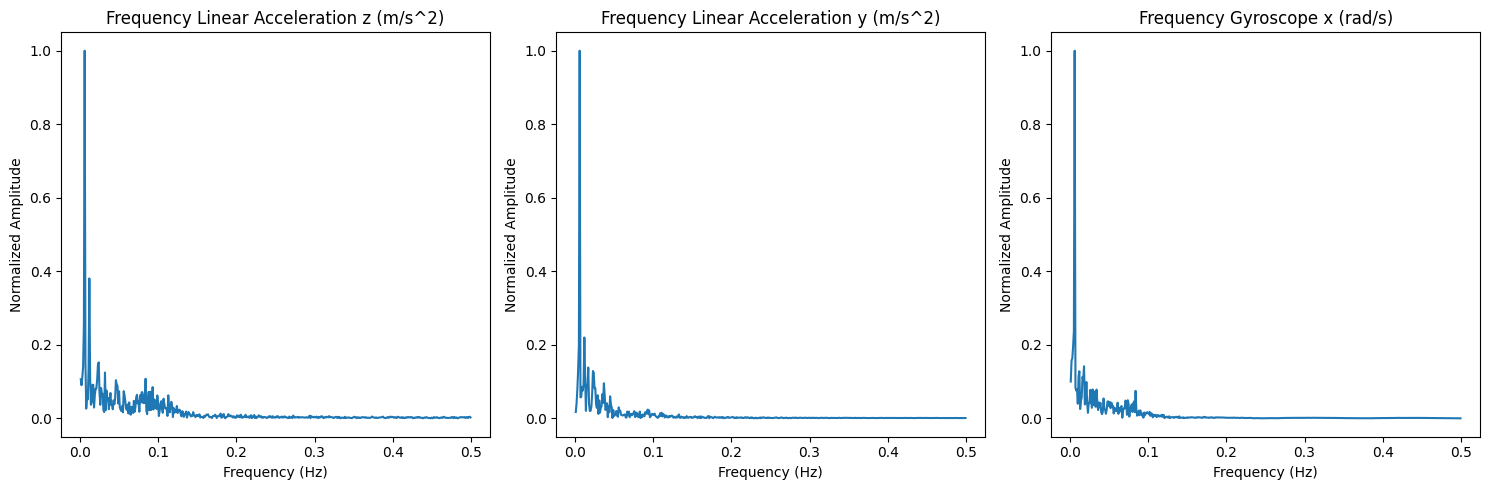

In [3681]:
plot_frequencies(squat_df)

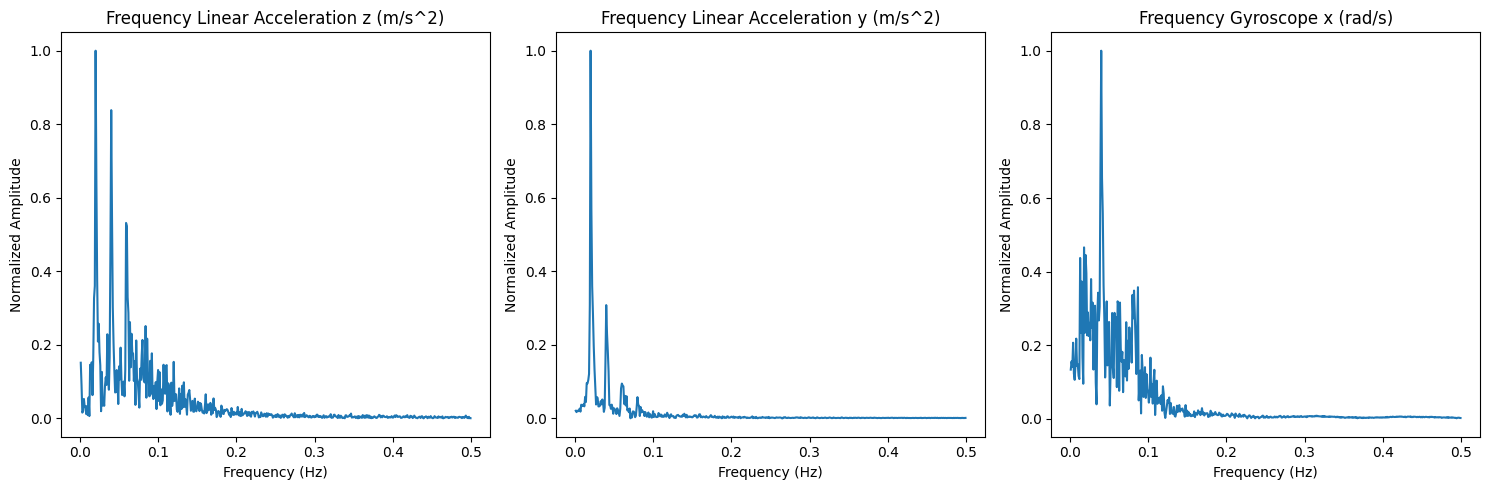

In [3682]:
plot_frequencies(jump_df)

### Filtern der Frequenzen

In [3683]:
def filter_frequency(dataframe):
    # Kopie des DataFrames erstellen
    filtered_dataframe = dataframe.copy()

    # Festlegen der Cutoff-Frequenz und der Filterordnung
    filter_order = 5
    low_cutoff = 10

    # Butterworth Tiefpass erstellen
    b, a = butter(filter_order, low_cutoff, btype='low', analog=False, fs=100)

    # Schleife über alle Spalten außer 'Time (s)'
    for column in dataframe.columns:
        if column != 'Time (s)':
            # Hochpassfilter auf die Signalreihe anwenden
            filtered_signal = filtfilt(b, a, dataframe[column])
            filtered_dataframe[column] = filtered_signal

    return filtered_dataframe

In [3684]:
filtered_df_sq = filter_frequency(squat_df)

In [3685]:
filtered_df_j = filter_frequency(jump_df)

In [3686]:
def plot_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [3687]:
def plot_normal_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Y'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Z'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Gyr_X'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

Frequenz gefiltert

In [3688]:
plot_df(filtered_df_j)

In [3689]:
plot_df(filtered_df_sq)

In [3690]:
# filtered_df_j_z = filtered_df_j.copy()
# # Korrekte Spaltennamen verwenden
# filtered_df_j_z['Z_Score_Y'] = stats.zscore(filtered_df_j['Linear Acceleration y (m/s^2)'])
# filtered_df_j_z['Z_Score_Z'] = stats.zscore(filtered_df_j['Linear Acceleration z (m/s^2)'])
# filtered_df_j_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_j['Gyroscope x (rad/s)']) 
# print(filtered_df_j_z.head())

# # Schwellenwert definieren
# z_score_threshold = 3

# # Ausreißer filtern
# filtered_df_j_z = filtered_df_j_z[(abs(filtered_df_j_z['Z_Score_Gyr_X']) <= z_score_threshold) &
#                                   (abs(filtered_df_j_z['Z_Score_Y']) <= z_score_threshold) &
#                                   (abs(filtered_df_j_z['Z_Score_Z']) <= z_score_threshold)]

def normalize_df(df, columns_to_scale):
    # Kopie des DataFrames erstellen
    normalized_df = df.copy()

    # Initialisieren des MinMaxScaler
    scaler = MinMaxScaler()

    # Fit des Scalers auf die Daten
    scaler.fit(normalized_df[columns_to_scale])

    # Transformieren der Daten
    normalized_columns = scaler.transform(normalized_df[columns_to_scale])
    
    # Ersetzen der Originaldaten durch die normalisierten Daten
    normalized_df[columns_to_scale] = normalized_columns

    return normalized_df

In [3691]:
# filtered_df_sq_z = filtered_df_sq.copy()
# # Korrekte Spaltennamen verwenden
# filtered_df_sq_z['Z_Score_Y'] = stats.zscore(filtered_df_sq['Linear Acceleration y (m/s^2)'])
# filtered_df_sq_z['Z_Score_Z'] = stats.zscore(filtered_df_sq['Linear Acceleration z (m/s^2)'])
# filtered_df_sq_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_sq['Gyroscope x (rad/s)']) 
# print(filtered_df_sq_z.head())

# # Schwellenwert definieren
# z_score_threshold = 3

# # Ausreißer filtern
# filtered_df_sq_z = filtered_df_sq_z[(abs(filtered_df_sq_z['Z_Score_Gyr_X']) <= z_score_threshold) &
#                                   (abs(filtered_df_sq_z['Z_Score_Y']) <= z_score_threshold) &
#                                   (abs(filtered_df_sq_z['Z_Score_Z']) <= z_score_threshold)]


In [3692]:
columns_to_normalize = ['Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Gyroscope x (rad/s)']

# Anwenden der Normalisierungsfunktion
normalized_df_sq = normalize_df(filtered_df_sq, columns_to_normalize)
normalized_df_j = normalize_df(filtered_df_j, columns_to_normalize)

# Nun sollten die normalisierten DataFrames auch die 'Time (s)' Spalte enthalten
print(normalized_df_sq.head())
print(normalized_df_j.head())

   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014470                       0.326626                       0.426912   
1  0.024510                       0.324089                       0.418365   
2  0.034490                       0.325527                       0.411895   
3  0.044499                       0.333424                       0.408953   
4  0.054448                       0.347696                       0.409946   

   Gyroscope x (rad/s)  
0             0.319429  
1             0.304981  
2             0.295430  
3             0.295156  
4             0.307343  
   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014226                       0.424769                       0.409299   
1  0.024235                       0.445719                       0.449473   
2  0.034215                       0.466370                       0.488342   
3  0.044224                       0.485782                       0.524424   
4 

Außreißer gefiltert

In [3693]:
plot_df(normalized_df_sq)

In [3694]:
plot_df(normalized_df_j)

In [3695]:
sq_peaks, _ = find_peaks(normalized_df_sq['Linear Acceleration y (m/s^2)'],prominence=0.5, height=0.5)
j_peaks, _ = find_peaks(normalized_df_j['Linear Acceleration y (m/s^2)'],prominence=0.5,height=0.5)


print(f"Anzahl der Peaks: {len(sq_peaks)}")
print(f"Anzahl der Peaks: {len(j_peaks)}")

Anzahl der Peaks: 5
Anzahl der Peaks: 20


In [3696]:
normalized_df_sq['Label'] = 'squat'
normalized_df_j['Label'] = 'jump'

In [3697]:
def create_windows_based_on_peaks(df, peaks):
    windows = []
    labels = []

    for i in range(len(peaks) - 1):
        # Berechnen der halben Fenstergröße als halber Abstand zum nächsten Peak
        half_window = int((peaks[i + 1] - peaks[i]) / 2)

        # Start- und Endindex des Fensters berechnen
        start_index = max(0, peaks[i] - half_window)
        end_index = min(len(df), peaks[i] + half_window)

        # Fenster erstellen
        window = df.iloc[start_index:end_index]
        windows.append(window)

        # Label des Peaks extrahieren
        labels.append(df.iloc[peaks[i]]['Label'])

    # Behandlung des letzten Peaks
    if len(peaks) > 1:
        last_peak = peaks[-1]
        half_window = int((last_peak - peaks[-2]) / 2)
        start_index = max(0, last_peak - half_window)
        end_index = min(len(df), last_peak + half_window)

        # Letztes Fenster hinzufügen
        window = df.iloc[start_index:end_index]
        windows.append(window)
        labels.append(df.iloc[last_peak]['Label'])
    elif len(peaks) == 1:
        # Falls nur ein Peak vorhanden ist, betrachten Sie das Fenster um diesen Peak
        half_window = 10  # Eine standardmäßige Fenstergröße
        start_index = max(0, peaks[0] - half_window)
        end_index = min(len(df), peaks[0] + half_window)

        window = df.iloc[start_index:end_index]
        windows.append(window)
        labels.append(df.iloc[peaks[0]]['Label'])

    # Erstellen eines DataFrame für Labels
    label_df = pd.DataFrame(labels, columns=['Label'])

    return windows, label_df


In [3698]:
sq_windows, sq_label_df = create_windows_based_on_peaks(normalized_df_sq, sq_peaks)

In [3699]:
j_windows,j_label_df = create_windows_based_on_peaks(normalized_df_j, j_peaks)

In [3700]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_windows_with_data(df, windows, peaks):
    # Farben für die Fenster in Accel Y definieren
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']

    # Erstellen des Plots mit Plotly
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accel Y', 'Gyro X', 'Accel Z'))

    # Hinzufügen der Accelerometer Y-Daten und Peaks
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y', line=dict(color='grey')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Time (s)'].iloc[peaks], y=df['Linear Acceleration y (m/s^2)'].iloc[peaks], mode='markers', marker=dict(color='red', size=5), name='Peaks Y'), row=1, col=1)

    # Hervorheben der Fenster in Accel Y mit verschiedenen Farben
    for i, window in enumerate(windows):
        window_color = colors[i % len(colors)]
        fig.add_trace(go.Scatter(x=window['Time (s)'], y=window['Linear Acceleration y (m/s^2)'], mode='lines', line=dict(color=window_color, width=2)), row=1, col=1)

    # Hinzufügen der Gyroscope X-Daten ohne farbliche Hervorhebung der Fenster
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], name='Gyro X', line=dict(color='blue')), row=2, col=1)

    # Hinzufügen der Linear Acceleration Z-Daten ohne farbliche Hervorhebung der Fenster
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z', line=dict(color='green')), row=3, col=1)

    # Update layout and labels
    fig.update_layout(title='Accelerometer Daten mit Peaks und farblichen Fenstern in Accel Y', xaxis_title='Zeit (s)', height=900)
    fig.show()

# plot_windows_with_data_interactive(df, windows, peaks)


In [3701]:
plot_windows_with_data(normalized_df_sq, sq_windows, sq_peaks)

In [3702]:
print(normalized_df_sq.describe())

          Time (s)  Linear Acceleration z (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.011073                       0.401277   
std       2.888941                       0.177720   
min       0.014470                       0.000000   
25%       2.512914                       0.267938   
50%       5.010961                       0.353044   
75%       7.509221                       0.540080   
max      10.007646                       1.000000   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                    1001.000000          1001.000000  
mean                        0.415112             0.514339  
std                         0.224512             0.267695  
min                         0.000000             0.000000  
25%                         0.221942             0.300005  
50%                         0.409946             0.503947  
75%                         0.585913             0.771117  
max                         1.000000      

In [3703]:
plot_windows_with_data(normalized_df_j, j_windows, j_peaks)

In [3704]:
print(normalized_df_j.describe())

          Time (s)  Linear Acceleration z (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.012072                       0.437722   
std       2.889771                       0.184675   
min       0.014226                       0.000000   
25%       2.512944                       0.307620   
50%       5.012181                       0.428465   
75%       7.511023                       0.536912   
max      10.009284                       1.000000   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                    1001.000000          1001.000000  
mean                        0.342551             0.423723  
std                         0.269165             0.159894  
min                         0.000000             0.000000  
25%                         0.124474             0.318982  
50%                         0.229050             0.412745  
75%                         0.551984             0.512274  
max                         1.000000      

In [3705]:
def balance_windows_and_labels(smaller_windows, larger_windows, smaller_label_df, larger_label_df):
    factor = int(len(larger_windows) / len(smaller_windows))
    smaller_windows_balanced = smaller_windows * factor
    smaller_label_df_balanced = pd.concat([smaller_label_df] * factor, ignore_index=True)

    # Überprüfen, ob zusätzliche Fenster benötigt werden
    if factor == 1:
        difference = len(larger_windows) - len(smaller_windows_balanced)
        additional_windows = smaller_windows[:difference]
        additional_labels = smaller_label_df.iloc[:difference]

        smaller_windows_balanced += additional_windows
        smaller_label_df_balanced = pd.concat([smaller_label_df_balanced, additional_labels], ignore_index=True)

    return smaller_windows_balanced, smaller_label_df_balanced


In [3706]:
print(f"Anzahl der Fenster für jump: {len(j_windows)}")
print(f"Anzahl der Fenster für squat: {len(sq_windows)}")

if len(sq_windows) < len(j_windows):
    # Balance Jump Windows to match Squat Windows
    sq_windows, sq_label_df = balance_windows_and_labels(sq_windows, j_windows, sq_label_df, j_label_df)
else:
    # Balance Squat Windows to match Jump Windows
    j_windows, j_label_df = balance_windows_and_labels(j_windows, sq_windows, j_label_df, sq_label_df)

print(f"Anzahl der Fenster für jump: {len(j_windows)}")
print(f"Anzahl der Fenster für squat: {len(sq_windows)}")

label_df = pd.concat([sq_label_df, j_label_df], ignore_index=True)
windows = sq_windows + j_windows


Anzahl der Fenster für jump: 20
Anzahl der Fenster für squat: 5
Anzahl der Fenster für jump: 20
Anzahl der Fenster für squat: 20


In [3707]:
print(label_df.tail())

   Label
35  jump
36  jump
37  jump
38  jump
39  jump


In [3708]:
# Leere Liste erstellen, um Features zu speichern
feature_list = []

# Jeden DataFrame in windows einzeln durchgehen und für jede der drei Achsen die Features berechnen
for window in windows:
    acc_y = window['Linear Acceleration y (m/s^2)']
    acc_z = window['Linear Acceleration z (m/s^2)']
    gyro_x = window['Gyroscope x (rad/s)']
    window_length = len(window)

    # Berechnete Werte an Liste anhängen, unter entsprechend benannten Spalten
    features = {
        'acc_y_peak': acc_y.max(),
        'acc_y_std_dev': acc_y.std(),
        'acc_y_variance': acc_y.var(),
        'acc_y_signal_energy': np.sum(acc_y**2) / window_length,
        'acc_z_peak': acc_z.max(),
        'acc_z_std_dev': acc_z.std(),
        'acc_z_variance': acc_z.var(),
        'acc_z_signal_energy': np.sum(acc_z**2) / window_length,
        'gyro_x_peak': gyro_x.max(),
        'gyro_x_std_dev': gyro_x.std(),
        'gyro_x_variance': gyro_x.var(),
        'gyro_x_signal_energy': np.sum(gyro_x**2)/ window_length
    }
    feature_list.append(features)

feature_df = pd.DataFrame(feature_list)

print(feature_df.head())


   acc_y_peak  acc_y_std_dev  acc_y_variance  acc_y_signal_energy  acc_z_peak  \
0    0.829830       0.220727        0.048720             0.249372    0.715989   
1    0.744762       0.221722        0.049161             0.196278    0.696758   
2    0.839695       0.227803        0.051894             0.247128    0.874421   
3    1.000000       0.243336        0.059212             0.225172    1.000000   
4    0.901423       0.244819        0.059936             0.228153    0.820922   

   acc_z_std_dev  acc_z_variance  acc_z_signal_energy  gyro_x_peak  \
0       0.139999        0.019600             0.227976     0.991838   
1       0.153613        0.023597             0.178802     1.000000   
2       0.182328        0.033243             0.210207     0.932383   
3       0.209580        0.043924             0.193279     0.930321   
4       0.206134        0.042491             0.189869     0.989027   

   gyro_x_std_dev  gyro_x_variance  gyro_x_signal_energy  
0        0.266251         0.07089

Genauigkeit des Entscheidungsbaum-Classifiers: 1.0


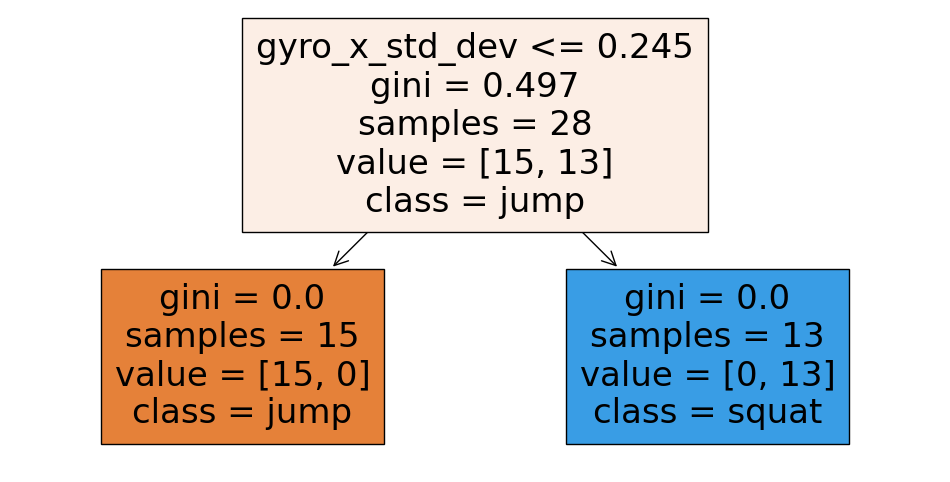

|--- gyro_x_std_dev <= 0.25
|   |--- class: jump
|--- gyro_x_std_dev >  0.25
|   |--- class: squat



In [3709]:
from sklearn.metrics import classification_report, confusion_matrix

X = feature_df
y = label_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Modell testen
y_pred = clf.predict(X_test)

# Erstelle und trainiere den Entscheidungsbaum-Classifier
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

# Mache Vorhersagen auf dem Testset
y_pred = clf.predict(X_test)

# Berechne die Genauigkeit des Classifiers
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit des Entscheidungsbaum-Classifiers: {accuracy}")

# Visualisiere den Entscheidungsbaum
plt.figure(figsize=(12, 6))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_)
plt.show()

# Visualisiere den Entscheidungsbaum in Textform
tree_text = export_text(clf, feature_names=X.columns.tolist())
print(tree_text)







Clustering

In [3710]:
from sklearn.cluster import KMeans

# Anzahl der gewünschten Cluster festlegen 
anzahl_cluster = 2  # Passe dies an deine Anforderungen an.

# Initialisierung des K-Means-Cluster-Algorithmus
kmeans = KMeans(n_clusters=anzahl_cluster, random_state=0)

# Clustering auf den Daten in 'feature_df' durchführen
cluster_labels = kmeans.fit_predict(feature_df)

# Berechnete Cluster zu jedem der Datenpunkte im Feature Dataframe zuordnungen
feature_df['Cluster'] = cluster_labels

# Gib das aktualisierte DataFrame mit Clusterzuordnungen aus.
#print(feature_df.head())
feature_df.columns


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Index(['acc_y_peak', 'acc_y_std_dev', 'acc_y_variance', 'acc_y_signal_energy',
       'acc_z_peak', 'acc_z_std_dev', 'acc_z_variance', 'acc_z_signal_energy',
       'gyro_x_peak', 'gyro_x_std_dev', 'gyro_x_variance',
       'gyro_x_signal_energy', 'Cluster'],
      dtype='object')

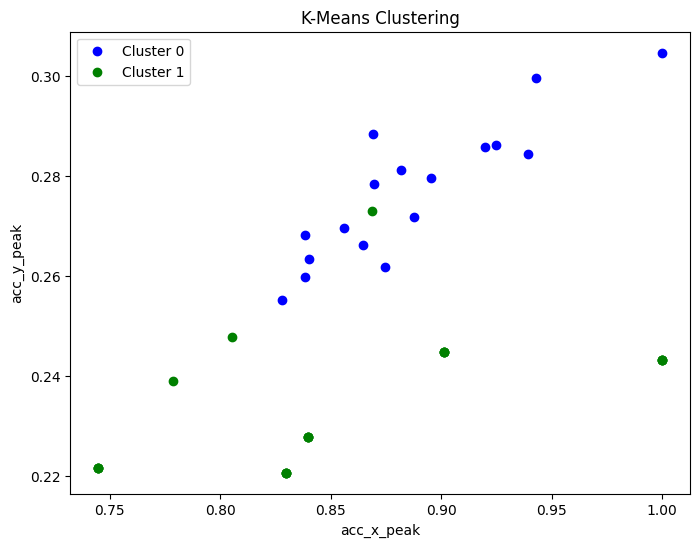

In [3711]:
# Visualisierung der Cluster
plt.figure(figsize=(8, 6))

# Erstelle eine Liste von Farben für die Cluster
farben = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Durchlaufen der Cluster und erstellen der Scatter-Plots für jeden Cluster
for cluster_id in range(anzahl_cluster):
    cluster_data = feature_df[feature_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['acc_y_peak'], cluster_data['acc_y_std_dev'], c=farben[cluster_id], label=f'Cluster {cluster_id}')
# Beschriftung des Diagramms
plt.xlabel('acc_x_peak')
plt.ylabel('acc_y_peak')
plt.title('K-Means Clustering')
plt.legend()

# Anzeigen des Scatter-Plots
plt.show()
